# <font color='orange'>DIP Exercise 06</font>

In [2]:
# Force CPU usage
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'      # 不使用GPU加速

import h5py   # 为Python提供了与分层数据格式版本5（HDF5）文件格式交互的接口。HDF5通常用于存储和管理大型复杂数据集
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob   # 提供了根据Unix shell使用的规则查找与指定模式匹配的所有路径名的功能

from skimage import io   # 模块提供了图像输入和输出的函数
from scipy.ndimage import gaussian_filter, gaussian_laplace, convolve, sobel
from skimage.feature import hessian_matrix, hessian_matrix_eigvals   # Hessian矩阵在图像处理中用于检测图像的局部特征。
from mpl_toolkits.mplot3d import Axes3D   # 用于绘制3D图形的Axes3D类

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D,\
                                    Dropout, concatenate, BatchNormalization

# Set random seed for reproducibility
np.random.seed(6)

## Gradient Operators

A large variety of tasks in image processing come down to finding and distinguishing structures（归结为寻找和区分结构）, as e.g. in matching finger prints, finding specific organs in CT images or cells of specific sizes in microscopy images. Since structures are characterized by local intensity（光强） changes, image derivatives（图像衍生物）provide good leads for structure enhancement. These derivatives can be defined in terms of finite differences.

图像处理中的大量任务归结为寻找和区分结构，例如匹配指纹，在CT图像中找到特定的器官或在显微镜图像中找到特定大小的细胞。由于结构以局部强度变化为特征，图像衍生物为结构增强提供了良好的线索。这些导数可以用有限差分来定义。

<img src='data/question_sign.png' width=20px height=20px style="float:left;"> There are three different kinds of finite differences in image data. Give the respective equation.

> - Forward difference: (f(x + h) - f(x)) / h
> - Backward difference:  (f(x) - f(x - h)) / h
> - Central difference: (f(x + h) - f(x - h)) / (2 * h)

<img src='data/question_sign.png' width=20px height=20px style="float:left;"> The following table shows incomplete first and second derivatives of a 1D signal. Complete the missing
entries and reconstruct the intensity values. Finally, draw the resulting signal (into the space above the table). Note: For calculation of the derivatives,
下表显示了一维信号的不完全一阶导数和二阶导数。完成缺失
输入并重建强度值。最后，绘制结果信号(到表上方的空白处)。注:计算导数时，
backward differences were used.> 
<img src='data/derivatives_missing.png' style="float:left;">

LINE 1 : 0 2 0 1 2 3

In the following example, the calculation of the forward difference in x-direction is shown for a patch showing
fluorescently labeled membranes.
在下面的例子中，在x方向上的向前差分的计算显示了一个补丁显示荧光标记膜。

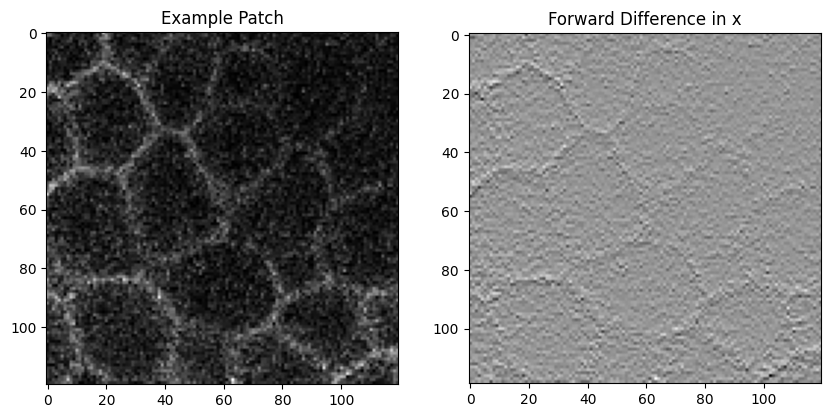

In [3]:
# Load and normalize a patch   定义图像块的尺寸和显示的切片位置
patch_size = [120, 120, 120]
show_slice = 50
with h5py.File(r'data/PNAS_meristem/thaliana_membranes_48h.h5', 'r') as file:
    # 从 HDF5 文件中提取 'data/image' 数据集并转换为 NumPy 数组
    img = np.array(file['data/image'])
    # 从图像中提取一个图像块
    img_patch = img[:patch_size[0], 200:200+patch_size[1], 200:200+patch_size[2]]
    # 转置图像块的维度，以匹配 Matplotlib 的预期维度顺序
    img_patch = np.transpose(img_patch, axes=(1,2,0))
    # 将图像块的数据类型转换为浮点型并进行归一化
    img_patch = img_patch.astype(float) # 将图像块的数据类型转换为浮点型
    img_patch -= img_patch.min() # 减去图像块中的最小值（使最小值为0）
    img_patch /= img_patch.max() # 将图像块的值进行归一化，使最大值为1   使得数组中的值在0到1之间

img_patch_forward_diff_x = img_patch[1:,...] - img_patch[:-1,...]
  
# Plot the result
fig, ax = plt.subplots(1,2, figsize=(10, 16))
ax[0].imshow(img_patch[...,show_slice], cmap="gray")
ax[0].set_title("Example Patch")
ax[1].imshow(img_patch_forward_diff_x[...,show_slice], cmap="gray")
ax[1].set_title("Forward Difference in x")
plt.show()

<img src='data/exclamation_sign.png' width=20px height=20px style="float:left;"> Compute the image gradient using central differences.

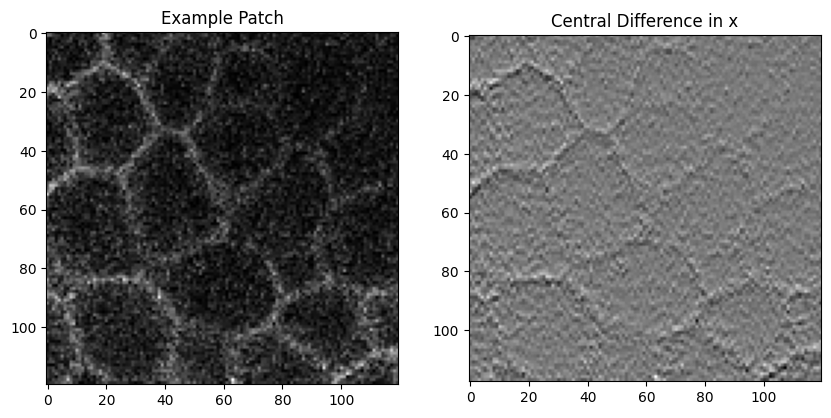

In [4]:
# 切片：第三个到最后img_patch[2:, ...]，从开始到倒数第三个img_patch[:-2, ...]
img_patch_central_diff_x = (img_patch[2:, ...] - img_patch[:-2, ...]) / 2

# Plot the result
fig, ax = plt.subplots(1,2, figsize=(10, 16))
ax[0].imshow(img_patch[...,show_slice], cmap="gray")
ax[0].set_title("Example Patch")
ax[1].imshow(img_patch_central_diff_x[...,show_slice], cmap="gray")
ax[1].set_title("Central Difference in x")
plt.show()

As you can see in the resulting image, finite differences are very sensitive to image noise. To obtain more
accurate results, the image should be smoothed before. Therefore, we use a Gaussian smoothing filter
with $\sigma = 2$.

从生成的图像中可以看到，有限差分对图像噪声非常敏感。为了获得更准确的结果，图像前应进行平滑处理。因此，我们使用高斯平滑滤波器
$\sigma = 2$。

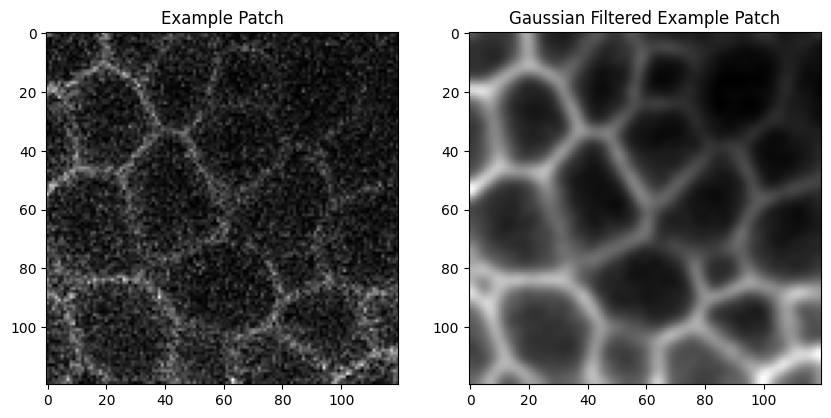

In [5]:
img_patch_gaussian = gaussian_filter(img_patch, 2)

# Plot the result
fig, ax = plt.subplots(1,2, figsize=(10, 16))
ax[0].imshow(img_patch[...,show_slice], cmap="gray")
ax[0].set_title("Example Patch")
ax[1].imshow(img_patch_gaussian[...,show_slice], cmap="gray")
ax[1].set_title("Gaussian Filtered Example Patch")
plt.show()

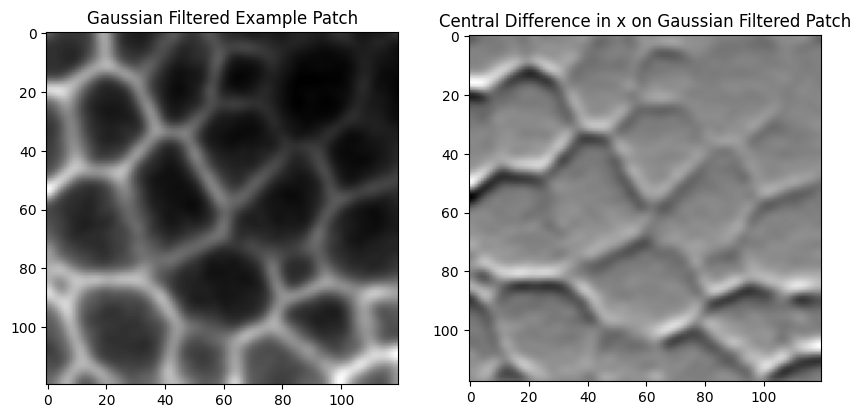

In [6]:
img_patch_gaussian_central_diff_x = (img_patch_gaussian[2:] - img_patch_gaussian[:-2]) / 2

# Plot the result
fig, ax = plt.subplots(1,2, figsize=(10, 16))
ax[0].imshow(img_patch_gaussian[...,show_slice], cmap="gray")
ax[0].set_title("Gaussian Filtered Example Patch")
ax[1].imshow(img_patch_gaussian_central_diff_x[...,show_slice], cmap="gray")
ax[1].set_title("Central Difference in x on Gaussian Filtered Patch")
plt.show()

Since this results in a much more pronounced image derivative, the resulting direction of the estimated
gradient will also be more accurate. To compute and visualize the gradient, we also calculate the gradient in
y-direction and get an estimate of the resulting direction.

由于这将导致更明显的图像导数，因此估计梯度的最终方向也将更加准确。为了计算和可视化梯度，我们还计算了y方向的梯度，并得到了结果方向的估计。

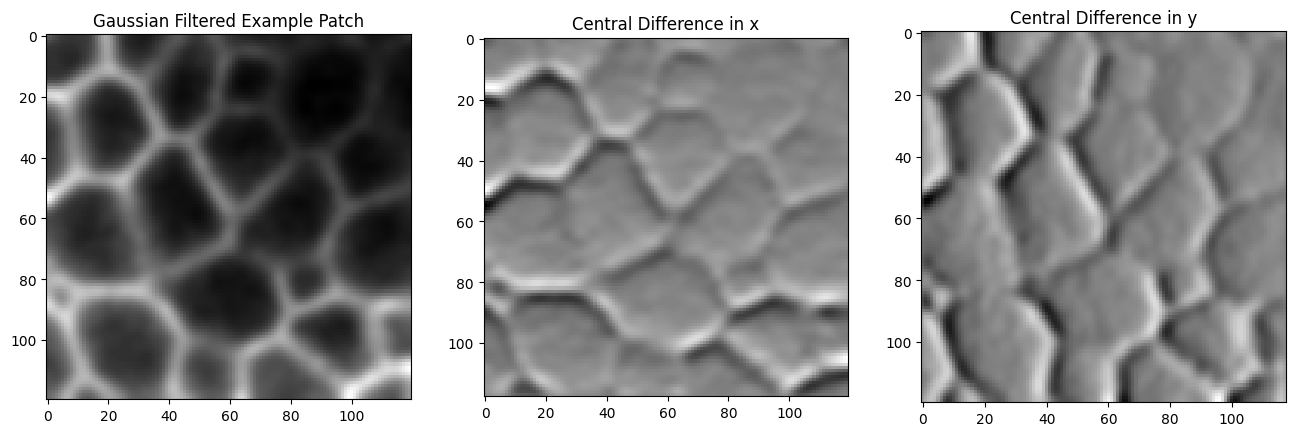

In [7]:
img_patch_gaussian_central_diff_y = (img_patch_gaussian[:,2:] - img_patch_gaussian[:,:-2]) / 2

# Plot the result
fig, ax = plt.subplots(1,3, figsize=(16, 24))
ax[0].imshow(img_patch_gaussian[...,show_slice], cmap="gray")
ax[0].set_title("Gaussian Filtered Example Patch")
ax[1].imshow(img_patch_gaussian_central_diff_x[...,show_slice], cmap="gray")
ax[1].set_title("Central Difference in x")
ax[2].imshow(img_patch_gaussian_central_diff_y[...,show_slice], cmap="gray")
ax[2].set_title("Central Difference in y")
plt.show()

For a better visualization, we can overlay the computed x- and y-differences with the image.

为了更好地可视化，我们可以将计算的x和y差与图像叠加。

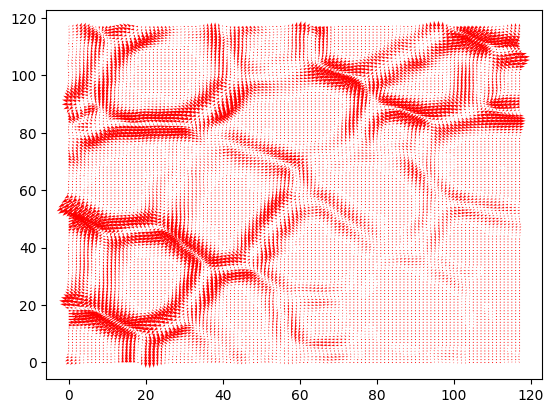

In [8]:
fig.set_size_inches(20, 20)   #设置图像窗口的大小为 20x20 英寸。

# 获取当前轴对象
ax = plt.gca()

ax.quiver(img_patch_gaussian_central_diff_x[:, :-2, show_slice], 
          img_patch_gaussian_central_diff_y[:-2, :, show_slice], 
          scale_units='xy', color='r')
plt.show()

Special filters can be designed in order to incorporate context into the calculation of the image gradient and thus to obtain results that are less sensitive to noise. Two of the most popular filters are the Sobel and Prewitt edge
detection filters.

可以设计特殊的滤波器，以便将上下文纳入图像梯度的计算，从而获得对噪声不太敏感的结果。两种最流行的滤波器是Sobel和Prewitt边缘检测滤波器。

<img src='data/question_sign.png' width=20px height=20px style="float:left;"> What's the main difference between both of these filters?

主要区别在于它们的卷积核（滤波模板）的形状和权重.
The main difference is the shape and weight of their convolution kernel (filter template)

<img src='data/question_sign.png' width=20px height=20px style="float:left;"> Which one of the following filters would be a better choice for edge detection/enhancement? Explain your
choice?

$\left[\begin{matrix}
2 & 2 & 2\\
0 & 0 & 0\\
-1 & -1 & -1
\end{matrix}\right ]\qquad\qquad
\left[\begin{matrix}
1 & 1 & 1\\
0 & 0 & 0\\
-1 & -1 & -1
\end{matrix}\right]$

The second filter would be better, since the sum of the elements equals zero, whereas the other flter would still ouput a signal inregions of constant intensity.

All of these approaches can also be extended to properly work along the third dimension by additionally computing differences in z-direction.

所有这些方法也可以通过额外计算z方向上的差异来扩展到沿着第三维正确地工作。

## Marr-Hildreth Operator

So far we only considered image gradients, which aim at finding edges or sharp changes of intensities in
general. Enhancing circular structures or determining their rough position, however, still remains challenging,
if only edges are considered.
To this end, the Marr-Hildreth (or Laplacian-of-Gaussian) operator was proposed, which is given by the
following formular:

到目前为止，我们只考虑了图像梯度，这些梯度旨在在一般情况下找到边缘或强烈的强度变化。然而，如果只考虑边缘，要增强圆形结构或确定其大致位置仍然是具有挑战性的。

$\nabla^2G(x,y) = \frac{dG(x,y)}{dx^2} + \frac{dG(x,y)}{dy^2} = (\frac{x^2 +y^2-2\sigma^2}{\sigma^4})e^{-\frac{x^2 + y^2}{2\sigma^2}}$

<img src='data/question_sign.png' width=20px height=20px style="float:left;"> Which parameter of the LoG controls the size of objects, the kernel is sensitive to?

LoG的哪个参数控制对象的大小，内核对其敏感?

Laplacian of Gaussian (LoG) 算子中的参数σ（标准差）控制对象的大小，内核对其敏感。这个参数决定了高斯滤波器的标准差，从而影响了LoG内核的尺寸。具体而言，较大的σ值会导致更大的内核尺寸，而较小的σ值会导致较小的内核尺寸。

DoG（Difference of Gaussian）函数
An approximation is given by the difference of two Gaussians:
近似是由两个高斯函数的差给出的

$D_G(x,y) = \frac{1}{2\pi\sigma_1^2}e^{-\frac{x^2 + y^2}{2\sigma_1^2}} - \frac{1}{2\pi\sigma_2^2}e^{-\frac{x^2 + y^2}{2\sigma_2^2}}$

The visual similarity between both filters is shown in the following plot. To be close to the shape of the LoG, standard deviations with a ratio of about 1.6 : 1 should be used.

两个过滤器之间的视觉相似性如下图所示。为了更接近LoG的形状，应该使用1.6:1左右的标准差。

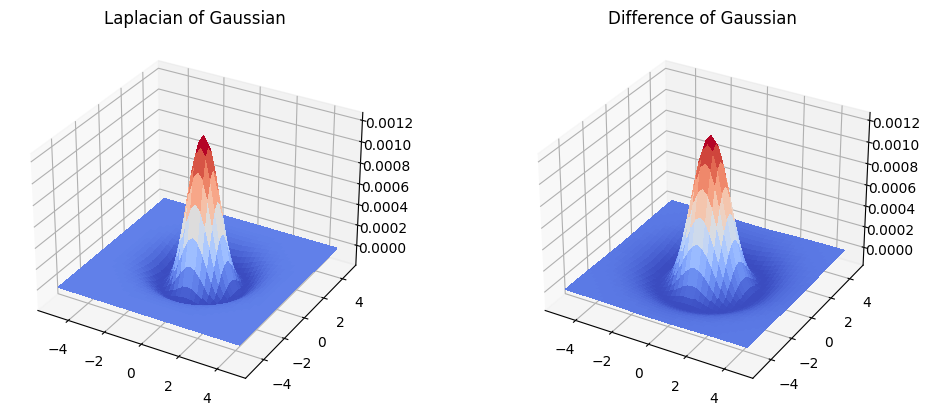

In [9]:
# 计算 LoG（Laplacian of Gaussian）和 DoG（Difference of Gaussian）函数，并将它们绘制成三维图像。
# Choose sigma
sigma = 4

# Calculate both filters
x_axis = np.arange(-5, 5, 0.25)
y_axis = np.arange(-5, 5, 0.25)
xg, yg = np.meshgrid(x_axis, y_axis)
impulse = np.zeros_like(xg)   #impulse 是一个与 xg 和 yg 大小相同的矩阵，其中一个位置被设置为 -1，表示一个脉冲信号。
impulse[20, 20] = -1
l_o_g = gaussian_laplace(impulse, sigma)
d_o_g = gaussian_filter(impulse, 1.6*sigma) - gaussian_filter(impulse, sigma)

# Match amplitudes
d_o_g /= d_o_g.max()/l_o_g.max()

# Plot both filters 
fig = plt.figure(figsize=plt.figaspect(0.4))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.plot_surface(xg, yg, l_o_g, 
                   cmap=mpl.cm.coolwarm,
                   linewidth=0, antialiased=False)
ax2.plot_surface(xg, yg, d_o_g, 
                   cmap=mpl.cm.coolwarm,
                   linewidth=0, antialiased=False)
ax1.set_title("Laplacian of Gaussian")
ax2.set_title("Difference of Gaussian")
plt.show()

In the following, we will compare both filters by finding fluorescently labeled cells. Zero-crossings can be used as edge detection.

接下来，我们将通过查找荧光标记的细胞来比较这两个滤波器。我们可以使用零交叉点作为边缘检测方法。

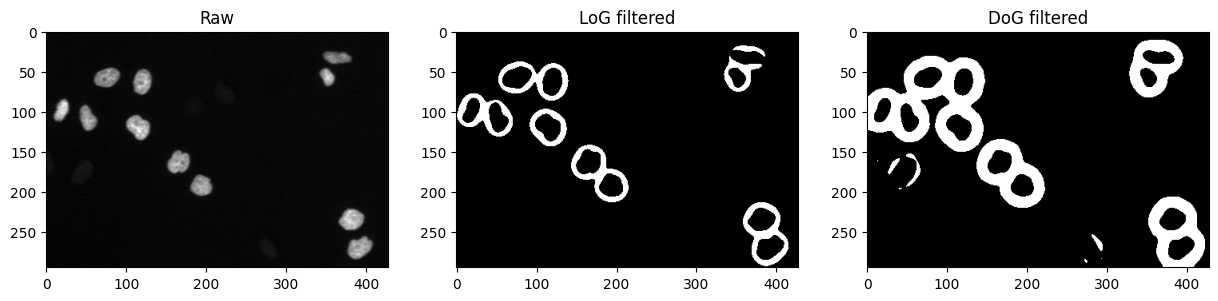

In [10]:

# Load the image
cells_img = io.imread(r'data/CTC_cells/cells.tif')
cells_img = cells_img.astype(int)

# Apply filters
cells_img_log = convolve(cells_img, l_o_g)
cells_img_dog = convolve(cells_img, d_o_g)

# Plot results
fig, ax = plt.subplots(1,3, figsize=(15, 20))
ax[0].imshow(cells_img, cmap="gray")
ax[1].imshow(cells_img_log<0, cmap="gray")   # 这个操作是因为 LoG 函数在边缘位置产生正负交叉，零交叉点就是边缘位置的标志。
ax[2].imshow(cells_img_dog<0, cmap="gray")
ax[0].set_title("Raw")
ax[1].set_title("LoG filtered")
ax[2].set_title("DoG filtered")
plt.show()

## Structure Tensor
One descriptor to analyze structures in the so called structure tensor.
一个用来分析结构张量的描述符。

<img src='data/question_sign.png' width=20px height=20px style="float:left;"> What's the structure tensor composed of?

gradient information of an image.

<img src='data/question_sign.png' width=20px height=20px style="float:left;"> For determining the local structures, again eigenvalues of the structure tensor are used. State, how the
following 3D structures can be distinguished, based on the eigenvalues $\lambda_1$, $\lambda_2$ and $\lambda_3$ of the structure tensor.

为了确定局部结构，再次使用结构张量的特征值。说明如何根据结构张量的特征值$\lambda_1$, $\lambda_2$ and $\lambda_3$来区分以下三维结构。

> - Constant region: 
> - Plane-like structure:
> - Rod-like structure: 
> - Spherical structure:

- **Constant region（恒定区域）**：当结构张量的所有特征值 $\lambda_1$, $\lambda_2$ and $\lambda_3$ 都接近于零时，表示恒定区域。这意味着在局部区域内，图像的强度变化非常小，基本上是均匀的。这种结构可能代表一个均匀的背景区域。

- **Plane-like structure（平面状结构）**：当两个特征值，例如$\lambda_1$和$\lambda_2$ ，相对较大，而第三个特征值 $\lambda_3$  较小时，表示平面状结构。这意味着在局部区域内，存在一个主导的平面，图像强度在该平面上的变化明显，但在平面的法线方向上变化较小。这种结构可能代表平面表面或者带有明显方向性的纹理。

- **Rod-like structure（棒状结构）**：当一个特征值，例如 $\lambda_1$，显著大于其他两个特征值 $\lambda_2$ and $\lambda_3$ 时，表示棒状结构。这表明在局部区域内存在一个主导的方向，图像强度沿着这个方向变化明显，而在其他两个方向上变化较小。这种结构可能代表细长的物体，如线条、管道或棒状物体。

- **Spherical structure（球状结构）**：当所有特征值 $\lambda_1$, $\lambda_2$ and $\lambda_3$  都相对较大时，表示球状结构。这表明在局部区域内，图像强度变化在所有方向上都较大，没有主导的方向。这种结构可能代表圆形或球形的物体，如球体或圆形细胞。

通过分析结构张量的特征值，我们可以推断图像中局部区域的几何结构和形状特征，这对于图像分析和计算机视觉任务非常有用。

To show how the structure tensor can be used to determine locations with a specific structure, we again load a patch of fluorescently labeled membranes.

为了展示如何使用结构张量来确定特定结构的位置，我们再次加载了一块荧光标记的膜。

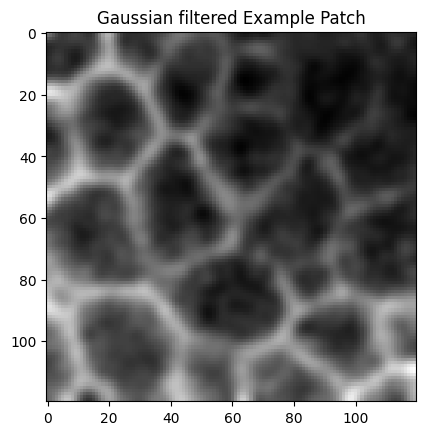

In [11]:
# Load the image, crops a patch and visualize it

patch_size = [1, 120, 120]
with h5py.File(r'data/PNAS_meristem/thaliana_membranes_48h.h5', 'r') as file:
    img = np.array(file['data/image'])
    img_patch = img[50:50+patch_size[0], 200:200+patch_size[1], 200:200+patch_size[2]]
    img_patch = np.transpose(img_patch, axes=[1,2,0])   # 通过np.transpose函数重新排列图像块的维度

def plot_img(img_patch, name):
    _ = plt.figure()
    ax = plt.gca()
    ax.imshow(img_patch[:,:,0] if img_patch.ndim == 3 else img_patch, cmap='gray')
    ax.set_title(name)

img_patch = (img_patch.astype('float32') - np.amin(img_patch)) / (np.amax(img_patch) - np.amin(img_patch)) #归一化
img_patch = (255 * img_patch ** 0.75) # exponent 0.75 defines gamma curve for contrast adjustment (see Lec.4)
img_patch_gaussian = gaussian_filter(img_patch, 2)
plot_img(img_patch_gaussian, "Gaussian filtered Example Patch")


Using the structure tensor for membrane localization is closely related to the approaches for structure
enhancement we learned before, since we don't aim at getting distinct detections. However, the result still
shows the tensor's sensitivity towards the membrane edges.

利用结构张量进行膜定位与我们之前学到的结构增强方法密切相关我们的目标不是得到明显的检测结果。然而，结果仍然显示了张量对膜边缘的敏感性。

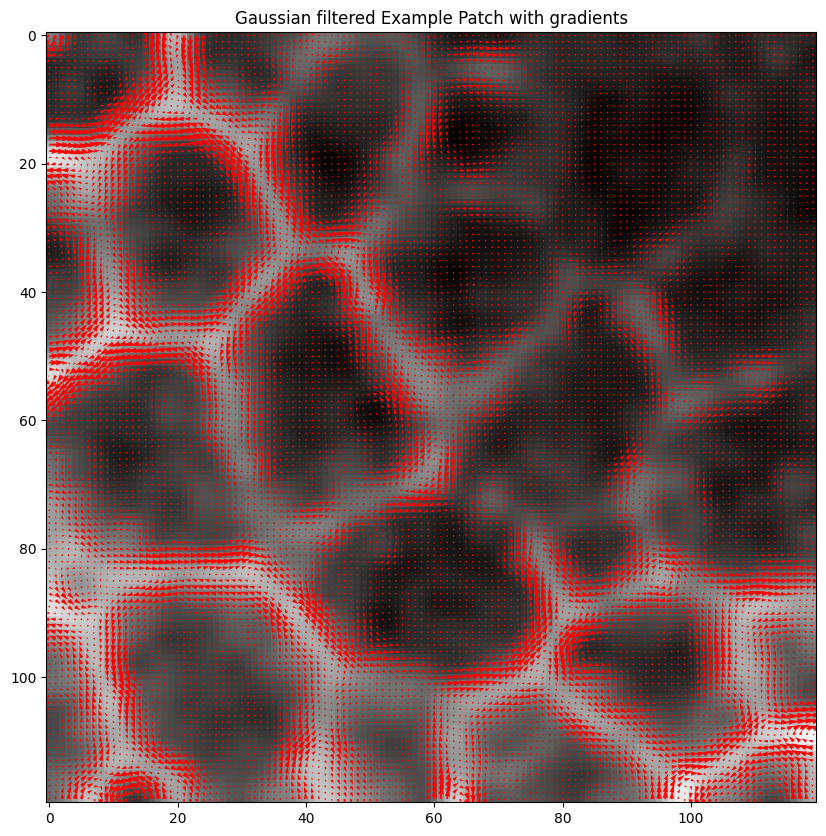

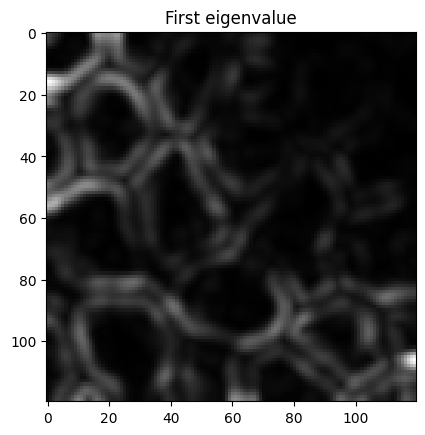

In [12]:
# Get directional gradients 
# To be less sentitive to noise, we use the gaussian filtered image
# 使用Sobel算子计算高斯滤波后图像块的水平和垂直方向的梯度
img_patch_gaussian_dx = sobel(img_patch_gaussian, 0)
img_patch_gaussian_dy = sobel(img_patch_gaussian, 1)

# Construct the structure tensor for a region of size 5x5 pixel  构建结构张量
nhood_filter = np.ones((5,5))/25

dx2 = img_patch_gaussian_dx ** 2
dy2 = img_patch_gaussian_dy ** 2
dxy = img_patch_gaussian_dx * img_patch_gaussian_dy 

hxx = convolve(dx2[:,:,0], nhood_filter)
hyy = convolve(dy2[:,:,0], nhood_filter)
hxy = convolve(dxy[:,:,0], nhood_filter)

# Calculate the eigenvalues of the structure tensor components  计算特征值
l1, l2 = hessian_matrix_eigvals([hxx, hxy, hyy])

# Plot the computed gradients directions and the first eigenvalue
plot_img(img_patch_gaussian, "Gaussian filtered Example Patch with gradients")
fig = plt.gcf()
fig.set_size_inches(10,10)
ax = plt.gca()
ax.quiver(img_patch_gaussian_dx[:,:,0], 
          img_patch_gaussian_dy[:,:,0], 
          scale_units='xy', color='r')
plot_img(l1, "First eigenvalue")
plt.show()

## Deep Learning-based Structure Enhancement

One of the most successful and most frequently used network architectures in biomedical image processing is the so called U-Net. It comprises a descending and an ascending part, with decreasing and increasing spatial dimensionality, respectively, or in other words, it includes an encoder and decoder part. This concept is very similar to the concept of autoencoders, but here, additional skip-connections are used.

生物医学图像处理中最成功和最常用的网络架构之一是所谓的U-Net。包括空间维数分别递减和递增的下降部分和上升部分，即包括编码器和解码器部分。这个概念与自动编码器的概念非常相似，但这里使用了额外的跳过连接。


<img src='data/u-net-architecture.png' width=500 height=500 > 

*Image: https://arxiv.org/pdf/1505.04597.pdf*

<img src='data/question_sign.png' width=20px height=20px style="float:left;"> What's the benefit of using an encoder-decoder architecture, i.e. why would one want to first downscale and then upscale again instead of keeping the original image size?

使用编码器-解码器架构的好处是什么，也就是说，为什么要先缩小尺寸，然后再扩大，而不是保持原始图像的大小?

编码器-解码器架构的主要优点在于它在学习有用特征的同时，能够实现图像压缩和重建。通过将图像编码为更低维的表示，然后解码回原始尺寸，这种架构可以实现许多图像处理和分析任务。以下是编码器-解码器架构的一些优点：

特征学习和表示学习：编码器-解码器架构可以通过编码器部分学习图像中的有用特征，这些特征可以捕获图像的重要信息，例如纹理、形状、边缘等。这种表示学习可以使得解码器部分更容易重建图像，因为它使用了更抽象的、有意义的特征。

降维和压缩：编码器-解码器架构在编码阶段将图像的尺寸降低，从而实现了图像的压缩。这对于存储和传输图像数据非常有用，特别是当处理大量图像数据时。

去除噪声和损失压缩：编码器-解码器架构可以学习将图像噪声减少到最小，并在解码时重建出干净的图像。这也被称为“去噪自编码器”。此外，由于信息损失的压缩，模型可以学习从图像中去除冗余信息，从而提高了模型的泛化能力。

数据增强和生成：在训练时，编码器-解码器架构可以用于生成增强的图像，从而增加数据集的多样性，有助于提高模型的泛化能力。

为什么要先缩小尺寸，然后再扩大，而不是保持原始图像的大小呢？这是因为将图像编码为较低维的表示可以聚焦于图像中的重要信息，同时过滤掉不必要的细节和噪声。然后，在解码阶段，模型可以从这种压缩的表示中重建出原始图像，保留重要的特征。这样做有助于减少模型需要学习的参数数量，提高了模型的泛化能力，并且可以应对不同大小的输入图像。此外，这种架构还可以对输入图像进行降噪和增强，从而提高图像质量。

Feature Extraction and Abstraction   Dimensionality Reduction  Noise and Outlier Suppression Noise and Outlier Suppression

the encoder-decoder architecture leverages downsampling and upsampling to extract relevant features, enhance computational efficiency, suppress noise, improve generalization, and address various image sizes. This approach is particularly effective for tasks like image denoising, super-resolution, style transfer, and semantic segmentation.

<img src='data/question_sign.png' width=20px height=20px style="float:left;"> What's the main idea behind skip-connections in the U-Net?

U-Net中跳过连接的主要思想是什么?

U-Net中跳过连接的**主要思想是在编码码器之器和解间建立直接连接**，以便将低级特征与高级特征进行融合。这种连接方式有助于解决传统编码器-解码器结构中信息丢失的问题，并能够提升模型在语义分割和图像分割等任务中的性能。具体来说，U-Net的跳过连接体现在以下几个方面：

1. **信息传递和重用**：在U-Net中，编码器层通过一系列卷积和池化操作逐渐捕获图像的抽象特征。然后，这些高级特征被传送到解码器部分以进行图像重建。然而，在这个过程中，编码器部分可能丢失了一些细节信息。跳过连接的引入允许从编码器层的不同深度传递信息到解码器，确保底层特征得以保留和重用。

2. **避免信息瓶颈**：在传统的编码器-解码器结构中，解码器的输入可能变得过于抽象，导致信息瓶颈和低分辨率输出。跳过连接允许解码器通过连接底层特征，以更丰富的上下文信息来生成高分辨率的输出。这有助于提高模型的细节保留能力。

3. **语义特征融合**：跳过连接使得底层和高层特征能够在解码器部分进行融合。这有助于模型在图像分割等任务中理解语义特征，从而更好地分割出对象、边界等关键部分。

4. **防止梯度消失和爆炸**：在深层神经网络中，梯度消失和梯度爆炸是常见问题。跳过连接可以缓解这些问题，因为底层特征通过直接连接传递给解码器，使得梯度能够更轻松地在网络中传播。

5. **位置信息保留**：跳过连接有助于保留底层特征的位置信息。在图像分割任务中，这对于精确定位目标和边界非常重要。

总之，U-Net中跳过连接的主要思想是在编码器和解码器之间添加直接连接，以促进低级特征和高级特征的融合，避免信息丢失，提升模型性能，以及改善图像分割等任务的表现。


The main idea of skipping connections in U-Net is to create a direct connection between the encoder and the decoder in order to fuse low-level features with high-level features. This connection helps to solve the problem of information loss in the traditional encoder-decoder structure, and can improve the performance of the model in semantic segmentation and image segmentation. Specifically, U-Net's skip connection is reflected in the following aspects:

1. ** Information transfer and reuse ** : In U-Net, the encoder layer gradually captures the abstract features of the image through a series of convolution and pooling operations. These advanced features are then transmitted to the decoder section for image reconstruction. However, in the process, the encoder part may have lost some details. The introduction of skipping connections allows information to be passed from different depths of the encoder layer to the decoder, ensuring that underlying features are retained and reused.

2. ** Avoid information bottlenecks ** : In the traditional encoder-decoder structure, the input to the decoder can become too abstract, resulting in information bottlenecks and low-resolution outputs. Skipping connections allows the decoder to generate high-resolution output with richer context information by connecting underlying features. This helps to improve the detail retention of the model.

3. ** Semantic feature fusion ** : Skip joins so that low-level and high-level features can be fused in the decoder part. This helps the model understand semantic features in tasks such as image segmentation, so as to better segment key parts such as objects and boundaries.

4. ** Prevent gradient disappearance and explosion ** : In deep neural networks, gradient disappearance and gradient explosion are common problems. Skipping connections can alleviate these problems because the underlying features are passed to the decoder via a direct connection, allowing gradients to propagate more easily across the network.

5. ** Location information retention ** : Skipping connections helps preserve location information for underlying features. In image segmentation tasks, this is very important for accurately locating targets and boundaries.

In summary, the main idea of skipping connections in U-Net is **to add direct connections between encoders and decoders to facilitate the fusion of low-level and high-level features**, avoid information loss, improve model performance, and improve the performance of tasks such as image segmentation.

To demonstrate the potential of the U-Net architecture, we will consider another 2D cell segmentation task. The data is provided by the [Cell Tracking Challenge](http://celltrackingchallenge.net/2d-datasets/) and specifically available with the training data set containing "*Glioblastoma-astrocytoma U373 cells on a polyacrylamide substrate*". 

可视化图像分割结果的函数
根据输入参数的数量，函数选择不同的可视化方式：

如果有额外的参数传入（即地面实况图像），函数会创建一个包含三个子图的图形，并在子图中分别绘制原始图像、预测的掩码和地面实况掩码。

如果没有额外的参数传入，函数同样会创建一个包含三个子图的图形，但在第三个子图中，它将原始图像与预测的掩码进行叠加显示，以显示掩码的分布。

这段代码的主要目的是可视化图像分割结果，让用户可以比较预测结果与地面实况的差异，或者观察掩码在原始图像上的覆盖情况。

In [13]:
def visualize_seg(image, mask, *args):   # 可视化图像分割结果的函数
    if len(args)>0:
        fig, ax = plt.subplots(1,3, figsize=(15, 24))
        ax[0].imshow(image, cmap="gray"); ax[0].set_title("Image")
        ax[1].imshow(mask, cmap="gray"); ax[1].set_title("Prediction")
        ax[2].imshow(args[0], cmap="gray"); ax[2].set_title("Ground Truth")
    else:
        fig, ax = plt.subplots(1,3, figsize=(15, 24))
        ax[0].imshow(image, cmap="gray"); ax[0].set_title("Image")
        ax[1].imshow(mask, cmap="gray"); ax[1].set_title("Mask")
        ax[2].imshow(image, cmap="gray"); 
        ax[2].imshow(mask, alpha=0.5, cmap=mpl.cm.coolwarm);
        ax[2].set_title("Overlay")

**加载训练数据集，对图像进行预处理，并将图像和对应的掩码准备好用于训练。**

使用glob模块遍历图像和掩码文件路径，加载图像和掩码，然后对它们进行降采样（下采样因子为2）。

将加载的图像和掩码数据追加到img_train和msk_train数组中。这里使用np.concatenate函数，将新数据连接到现有的数组中。

为图像和掩码数组添加一个通道维度，使其成为三维数组，形状为(数量, 高度, 宽度, 通道数)。

对图像进行归一化，将像素值范围映射到[0, 1]区间。首先计算图像的2%和98%分位数，然后使用这些值对图像进行线性拉伸。

将掩码二值化，将非零值设置为1，以得到二值掩码。

In [15]:
# Load the TRAIN set
img_train = np.array([])
msk_train = np.array([])
for image_path, mask_path in zip(glob.glob(r'data/PhC-C2DH-U373/01_img/*.tif'), \
                                 glob.glob(r'data/PhC-C2DH-U373/01_msk/*.tif')):
    new_img = io.imread(image_path)
    new_img = new_img[::2,::2]
    new_msk = io.imread(mask_path)
    new_msk = new_msk[::2,::2]
    img_train = np.concatenate((img_train, new_img[np.newaxis]), axis=0) \
                if img_train.size else new_img[np.newaxis]
    msk_train = np.concatenate((msk_train, new_msk[np.newaxis]), axis=0) \
                if msk_train.size else new_msk[np.newaxis]
    
# Add channel dimension
img_train = img_train.reshape((*img_train.shape, 1))
msk_train = msk_train.reshape((*msk_train.shape, 1))

# Normalize the images
img_train = img_train.astype(float)
p02, p98 = np.percentile(img_train, [2,98])
img_train = (img_train - p02) / (p98 - p02)
img_train = np.clip(img_train, 0, 1)

# Binarize the masks
msk_train[msk_train!=0] = 1

这段代码执行以下步骤：

使用np.random.choice函数从训练数据集中随机选择两个索引，用于随机选择两个训练样本。

遍历所选索引，对每个样本执行以下操作：

调用visualize_seg函数，将图像和掩码传递给函数进行可视化。如果函数的参数超过两个，则同时显示预测结果和真实掩码。
总之，这段代码用于随机选择两个训练样本并可视化它们的图像和掩码。这有助于检查数据预处理是否正确以及样本是否符合预期。

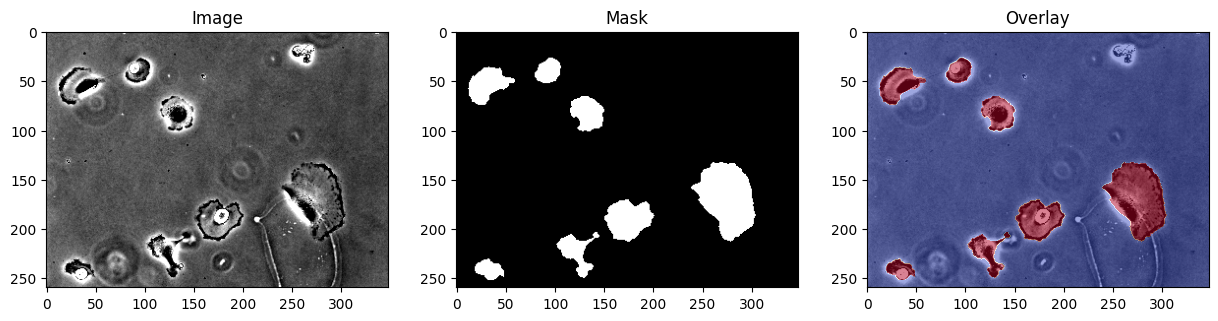

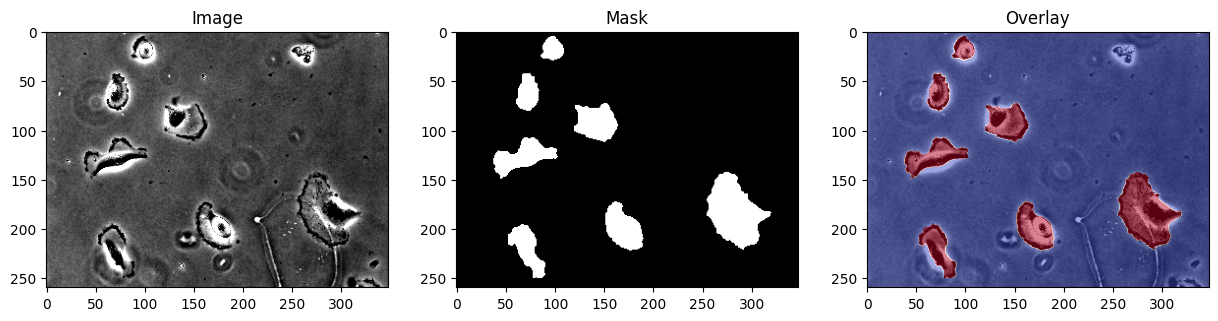

In [16]:
# Showcase random samples from the train set
idcs = np.random.choice(img_train.shape[0], 2)
for idx in idcs:
    visualize_seg(img_train[idx,:,:,0], msk_train[idx,:,:,0])

这段代码执行以下操作：

使用tf.keras.backend.clear_session()清除当前的 Keras 图。

定义了一个函数unet，该函数创建了 U-Net 网络架构。U-Net 是一个编码器-解码器架构，用于图像分割任务。

在编码路径中，使用卷积层和池化层逐步降低特征图的尺寸，以便学习图像的高级特征。

在解码路径中，使用反卷积层将特征图尺寸恢复到原始尺寸，同时将来自编码路径的特征图与解码路径中的特征图进行合并，以便进行更精确的分割。

使用model.compile编译模型，设置优化器为 Adam，损失函数为二进制交叉熵，度量指标为准确率。

打印模型摘要，显示模型的结构和参数统计。

总之，这段代码定义了一个 U-Net 模型，适用于图像分割任务，并对其进行了编译和摘要打印。

In [17]:
# Reset the current Keras graph
tf.keras.backend.clear_session()

# Define the network architecture
def unet(input_size = (img_train.shape[1],img_train.shape[2],1)):
    inputs = Input(input_size)
    conv1 = Conv2D(8, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(8, 3, activation='relu', padding='same')(conv1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)
    
    conv2 = Conv2D(16, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(16, 3, activation='relu', padding='same')(conv2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    
    conv4 = Conv2D(32, 3, activation='relu', padding='same')(pool2)
    conv4 = Conv2D(32, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    
    up2 = Conv2DTranspose(16, 2, activation='relu', strides=2, padding='same')(drop4)
    merge2 = concatenate([drop2,up2], axis=3)
    conv6 = Conv2D(16, 3, activation='relu', padding='same')(merge2)
    conv6 = Conv2D(16, 3, activation='relu', padding='same')(conv6)

    up3 = Conv2DTranspose(8, 2, activation='relu', strides=2, padding='same')(conv6)
    merge3 = concatenate([conv1,up3], axis=3)
    conv7 = Conv2D(8, 3, activation='relu', padding='same')(merge3)
    conv7 = Conv2D(1, 3, activation='sigmoid', padding='same')(conv7)

    model = tf.keras.Model(inputs, conv7, name="u-net")

    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    model.summary()

    return model

unet = unet()

Model: "u-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 260, 348, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 260, 348, 8)  80          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 260, 348, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 260, 348, 8)  0           ['conv2d_1[0][0]']           

使用已加载的数据集（img_train 和 msk_train）对 U-Net 模型进行训练。

num_epochs 定义了训练的轮数，这里设置为 20。

unet.fit 是 Keras 中用于训练模型的方法。它接受训练图像数据（img_train）和相应的标签（msk_train），以及其他参数。

batch_size 设置了每个训练批次的样本数量。

epochs 指定了训练的轮数。

validation_split 是将训练数据划分为训练集和验证集的比例。在这里，将 20% 的数据用作验证集。

shuffle=True 表示在每个轮次开始之前，是否对训练数据进行随机重排。

训练过程将在指定的轮数内进行，每轮完成后会显示训练和验证的损失值、准确率等信息。

总之，这段代码用加载的数据集对 U-Net 模型进行了训练，训练轮数为 20 轮。训练的过程将根据指定的参数进行。

In [19]:
# Train the network using the loaded data set
num_epochs = 20
train_history = unet.fit(img_train, msk_train, batch_size=4, epochs=num_epochs,
                         validation_split=0.2, shuffle=True) 

Epoch 1/20
23/23 [==============================] - 7s 266ms/step - loss: 0.5439 - accuracy: 0.9173 - val_loss: 0.4683 - val_accuracy: 0.9108
Epoch 2/20
23/23 [==============================] - 6s 272ms/step - loss: 0.3671 - accuracy: 0.9204 - val_loss: 0.3799 - val_accuracy: 0.9109
Epoch 3/20
23/23 [==============================] - 7s 287ms/step - loss: 0.2063 - accuracy: 0.9204 - val_loss: 0.1382 - val_accuracy: 0.9109
Epoch 4/20
23/23 [==============================] - 7s 304ms/step - loss: 0.1124 - accuracy: 0.9204 - val_loss: 0.1173 - val_accuracy: 0.9108
Epoch 5/20
23/23 [==============================] - 8s 354ms/step - loss: 0.0944 - accuracy: 0.9242 - val_loss: 0.1109 - val_accuracy: 0.9260
Epoch 6/20
23/23 [==============================] - 8s 362ms/step - loss: 0.0842 - accuracy: 0.9624 - val_loss: 0.0939 - val_accuracy: 0.9650
Epoch 7/20
23/23 [==============================] - 8s 341ms/step - loss: 0.0717 - accuracy: 0.9740 - val_loss: 0.0776 - val_accuracy: 0.9708
Epoch 

用于绘制训练和验证损失值随训练轮数变化的曲线

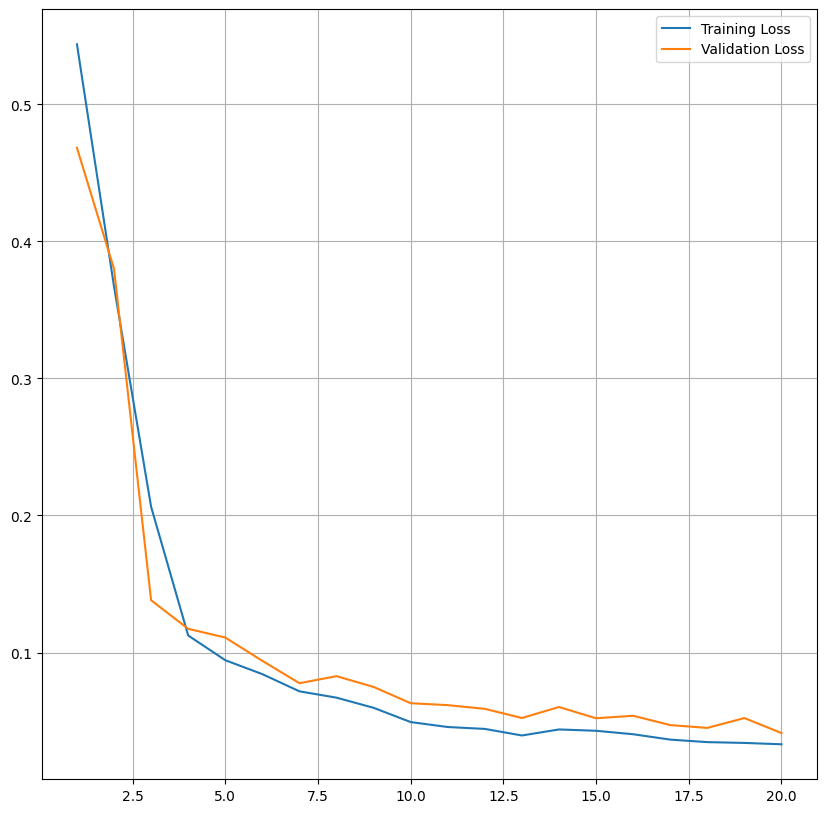

In [20]:
# Plot training & validation loss values
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

plt.figure(figsize=[10,10])
plt.plot(np.arange(1, num_epochs+1), loss)
plt.plot(np.arange(1, num_epochs+1), val_loss)
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

加载测试数据集，并进行与训练数据集类似的预处理操作  测试数据集被准备好供模型进行预测和性能评估。

In [21]:
# Load the TEST set
img_test = np.array([])
msk_test = np.array([])
for image_path, mask_path in zip(glob.glob(r'data/PhC-C2DH-U373/02_img/*.tif'), \
                                 glob.glob(r'data/PhC-C2DH-U373/02_msk/*.tif')):
    new_img = io.imread(image_path)
    new_img = new_img[::2,::2]
    new_msk = io.imread(mask_path)
    new_msk = new_msk[::2,::2]
    img_test = np.concatenate((img_test, new_img[np.newaxis]), axis=0) \
                if img_test.size else new_img[np.newaxis]
    msk_test = np.concatenate((msk_test, new_msk[np.newaxis]), axis=0) \
                if msk_test.size else new_msk[np.newaxis]
    
# Add channel dimension
img_test = img_test.reshape((*img_test.shape, 1))
msk_test = msk_test.reshape((*msk_test.shape, 1))

# Normalize the images
img_test = img_test.astype(float)
p02, p98 = np.percentile(img_test, [2,98])
img_test = (img_test - p02) / (p98 - p02)
img_test = np.clip(img_test, 0, 1)

# Binarize the masks
msk_test[msk_test!=0] = 1

目的是通过随机选择的测试样本来展示模型的预测效果，并将预测结果与真实掩膜进行比较。这有助于评估模型在测试数据上的性能。

1/1 [==============================] - 0s 30ms/step


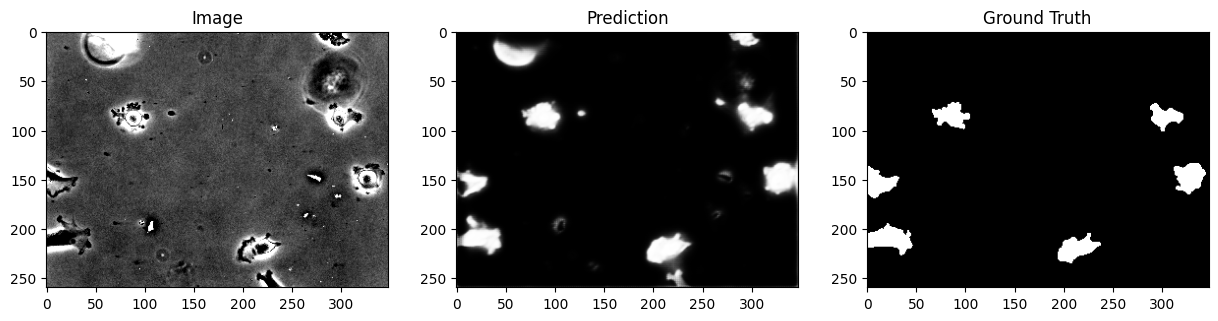

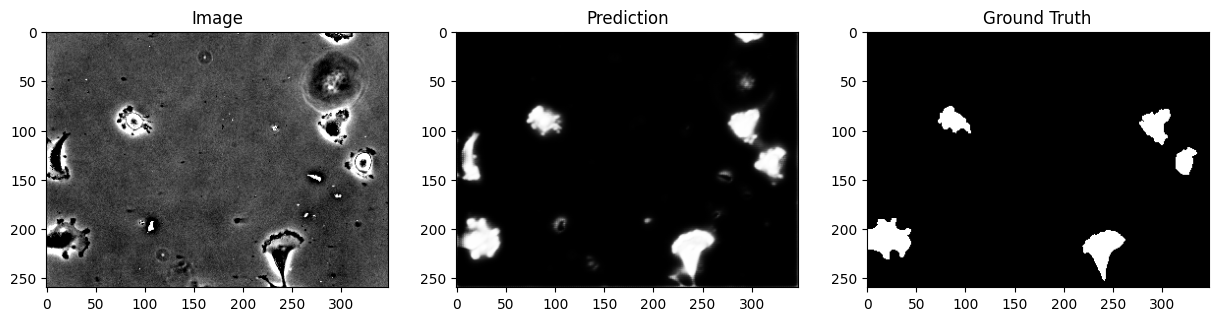

In [22]:
# Predict and visualize random samples from the test set
idcs = np.random.choice(img_test.shape[0], 2)
for idx in idcs:
    msk_predict = unet.predict(img_test[idx:idx+1])
    visualize_seg(img_test[idx,...,0], msk_predict[0,...,0], msk_test[idx,...,0])

<img src='data/question_sign.png' width=20px height=20px style="float:left;"> Assume the network was trained on images containing only one single cell each. Would the network still be able to achieve good results for images with multiple cells, assuming they don't touch each other?

假设网络是在只包含一个单元格的图像上训练的。假设多个细胞互不接触，该网络是否仍然能够对具有多个细胞的图像取得良好的结果?

The network applies convolutions, which are inherently translation invariant, e.g. the filter response fortwo identical objects in two different locations in the image will be the same. Therefore, the network isstill able to find multiple objects, although it was only trained with individually occuring objects.

该网络应用卷积，这是固有的平移不变性，例如，图像中两个不同位置的两个相同物体的滤波器响应将是相同的。因此，网络仍然能够找到多个对象，尽管它只使用单独出现的对象进行训练。

<img src='data/question_sign.png' width=20px height=20px style="float:left;"> In order to stabilize training, batch-normalization can be used. Briefly explain the working principle of
batch-normalization.

为了稳定训练，可以采用批归一化方法。简述批归一化的工作原理。

Batch-normalization re-centers and re-scales the activations within each layer, by stochasticallynormalizing each batch to zero mean and unit standard deviation. Since twis would lead to a loss ofdiscriminative power additional scaling and offset parameters are learned during training. Similar tonormalizing the input data, normalizing each activation within the network helps to stabilize andspeed-up the training process and to suppress possible outlier activation values.

批归一化通过将每个批随机归一化到零均值和单位标准差，重新中心和重新缩放每层内的激活。由于扭曲会导致判别能力的损失，在训练过程中学习额外的缩放和偏移参数。与规范化输入数据类似，规范化网络中的每个激活有助于稳定和加速训练过程，并抑制可能的异常激活值。